# **Superconductivity Regression Notebook**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/features.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is to test results in a graphical format, in bulk or as a single model. Our actual results are produced with the relevent .py scripts, ran on the compute farm.

*Author: Kirk Kleinsasser*

In [1]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

Autosaving every 300 seconds


In [2]:
#TODO: Do SVR optimization. Redo extratrees optimzation with just n_est. Try RFR more. Try Superlearner more?

#TODO: maybe do comparision of params vs scores
#physics-informed ML 
#lolopy - uncertainty, at least for RFR
#citrine informatics 
#

#calculated data in materials project is for idiv samples, aflow (27 compositions, can try if I get time), 
#next meeting - go thru next steps, if calculated datasets is too much
#finish uncertainty stuff
#compare lolopy/forestci/mapie, do into details --> not in previous papers

#spend more time on lolopy if it doesn't work

#start document explaining steps in more detail on optimization choices and such, latex

## Import Libraries / Define Import Data Function

In [2]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #error for RFR

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR

#various ML tools:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error

#imports custom libraries (shared functions)
import dependancies.shared_functions as sfn 
from dependancies.superlearner import get_superlearner as Superlearner

[MLENS] backend: threading


## Single Results

Starting training on Linear Regression
('Linear Regression', 314.499, 13.147, 92.049, 0.608, 76.753)


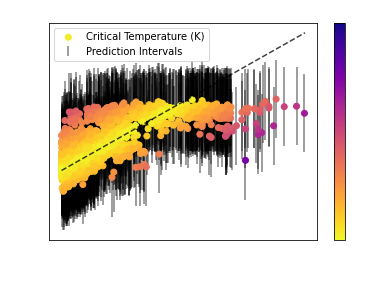

<Figure size 432x288 with 0 Axes>

In [2]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Linear Regression", LinearRegression, {}, uncertainty=True, method="plus")

In [4]:
sfn.import_data(replace_inf=True) #reimport data without infinities

sfn.evaluate_one("Superlearner", Superlearner, {'X': sfn.train_data}, uncertainty=True, method="plus", image=True)

Starting training on Random Forest Regression


/home/sylphrena/anaconda3/envs/CLASSE/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+06, tolerance: 8.767e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


('Random Forest Regression', 71.956, 4.36, 81.838, 0.91, 38.916)


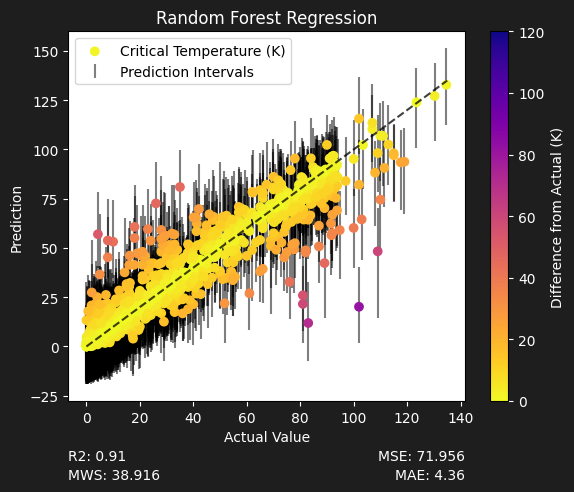

<Figure size 640x480 with 0 Axes>

In [5]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest Regression", RandomForestRegressor, {}, uncertainty=True, method="plus") 

Starting training on Random Forest - GridSearchCV
('Random Forest - GridSearchCV', 71.265, 4.315, 81.87, 0.911, 38.505)


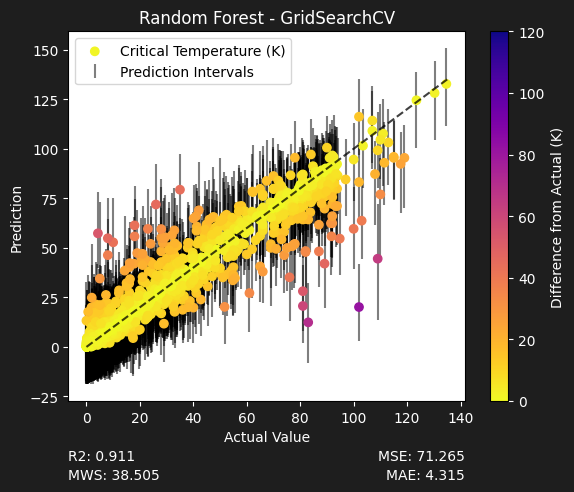

<Figure size 640x480 with 0 Axes>

In [21]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest - GridSearchCV", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="plus")

Starting training on Random Forest - Bayesian Optimized
('Random Forest - Bayesian Optimized', 72.279, 4.358, 80.399, 0.91, 38.076)


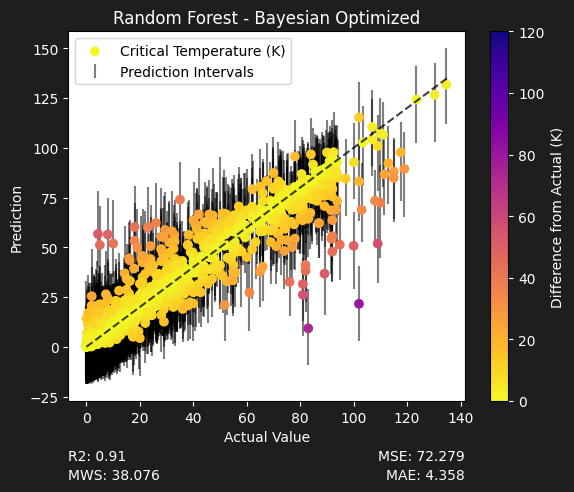

<Figure size 640x480 with 0 Axes>

In [4]:
sfn.evaluate_one("Random Forest - Bayesian Optimized", RandomForestRegressor, {'max_features':19, 'n_estimators':226, 'n_jobs':-1})

Starting training on Extra Trees - GridSearchCV
('Extra Trees - GridSearchCV', 59.181, 3.785, 76.297, 0.926, 35.625)


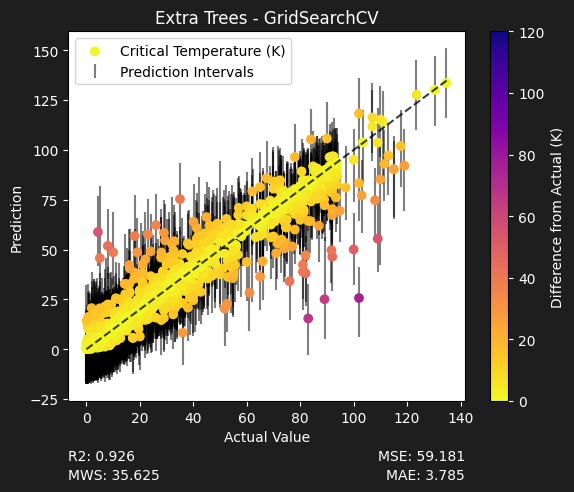

<Figure size 640x480 with 0 Axes>

In [18]:
sfn.evaluate_one("Extra Trees - GridSearchCV", ExtraTreesRegressor, {'n_estimators': 589}, uncertainty=True, method="plus")

## Generate Uncertainty Comparison

In [6]:
sfn.import_data(replace_inf=True) #try more MAPIE methods if time - https://mapie.readthedocs.io/en/latest/generated/mapie.regression.MapieRegressor.html
sfn.evaluate_one("Random Forest - Optimized (ForestCI)", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, forestci=True, background=False, image=True, show=False)
sfn.evaluate_one("Random Forest - Optimized (MAPIE-base)", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="base", background=False, image=True, show=False)
sfn.evaluate_one("Random Forest - Optimized (MAPIE-naive)", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="naive", background=False, image=True, show=False)
sfn.evaluate_one("Random Forest - Optimized (MAPIE-minmax)", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="minmax", background=False, image=True, show=False)
sfn.evaluate_one("Random Forest - Optimized (MAPIE-plus)", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 250}, uncertainty=True, method="plus", background=False, image=True, show=False)

Starting training on Random Forest - Optimized (ForestCI)
(1868,)
('Random Forest - Optimized (ForestCI)', 71.917, 4.358, 80.637, 0.91, None)
Starting training on Random Forest - Optimized (MAPIE-base)
('Random Forest - Optimized (MAPIE-base)', 71.917, 4.358, 80.637, 0.91, 38.007)
Starting training on Random Forest - Optimized (MAPIE-naive)
('Random Forest - Optimized (MAPIE-naive)', 71.917, 4.358, 80.637, 0.91, 13.662)
Starting training on Random Forest - Optimized (MAPIE-minmax)
('Random Forest - Optimized (MAPIE-minmax)', 71.917, 4.358, 80.637, 0.91, 40.612)
Starting training on Random Forest - Optimized (MAPIE-plus)
('Random Forest - Optimized (MAPIE-plus)', 71.917, 4.358, 80.637, 0.91, 38.302)


<Figure size 640x480 with 0 Axes>

## Bulk Results

Starting training on Elastic Net Regression
('Elastic Net Regression', 389.897, 14.877, 85.514, 0.513, 86.375)
Starting training on Decision Tree Regression
('Decision Tree Regression', 135.041, 5.529, 90.2, 0.831, 56.136)
Starting training on Bayesian Regression
('Bayesian Regression', 314.711, 13.172, 88.627, 0.607, 76.994)
Starting training on Random Forest Regression
('Random Forest Regression', 72.112, 4.349, 81.294, 0.91, 39.254)
Starting training on Support Vector Machines
('Support Vector Machines', 561.031, 15.524, 103.627, 0.3, 116.254)
Starting training on Extra Trees Regression
('Extra Trees Regression', 58.565, 3.792, 75.4, 0.927, 35.85)
Starting training on Linear Regression
('Linear Regression', 314.499, 13.147, 92.049, 0.608, 76.753)
Starting training on KNeighbors Regression
('KNeighbors Regression', 157.93, 6.897, 81.02, 0.803, 58.275)


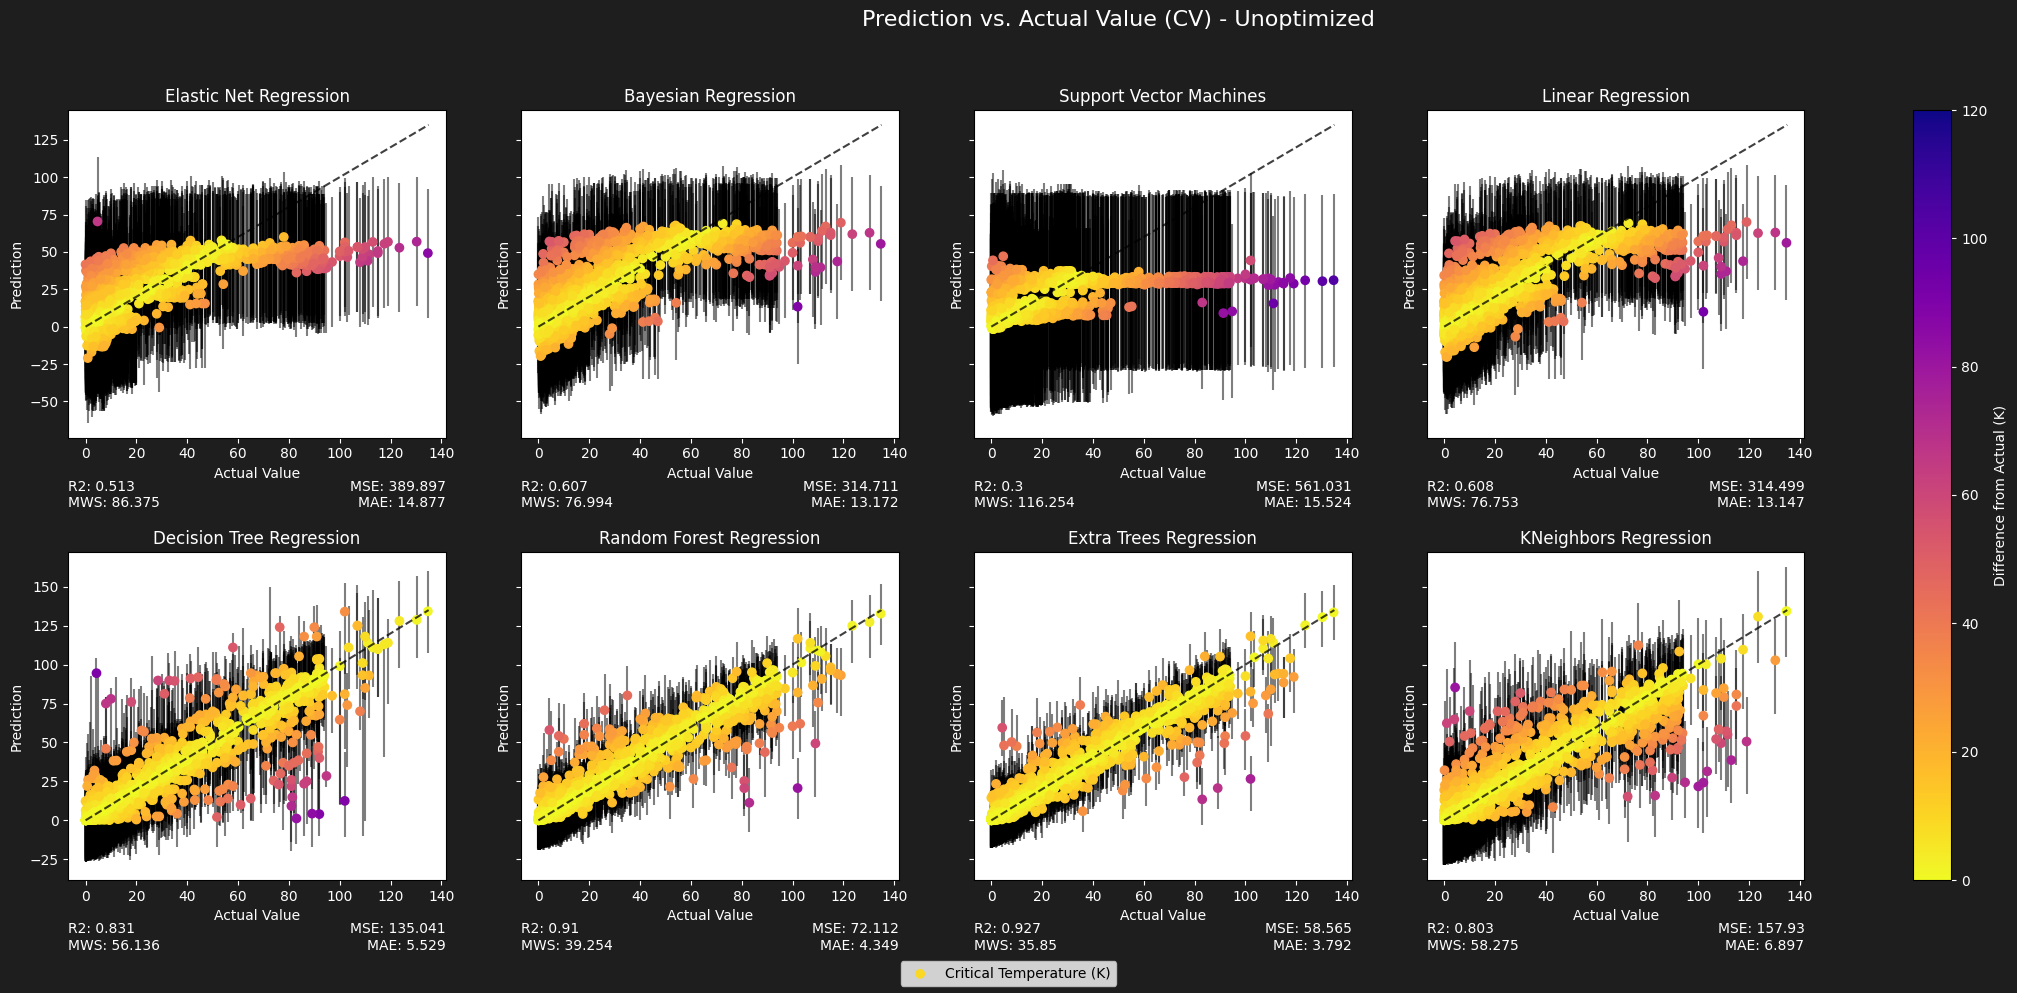

In [7]:
sfn.import_data(replace_inf=True)

#defines the models in a list of pairs of lists. The first item in a pair is the top graph in a column, the second is the bottom. The last item of a model is to enable error
models  =  ((("Elastic Net Regression", ElasticNet, {}, True),                 ("Decision Tree Regression", DecisionTreeRegressor, {}, True)),
            (("Bayesian Regression", BayesianRidge, {}, True),                 ("Random Forest Regression", RandomForestRegressor, {}, True)),
            (("Support Vector Machines", SVR, {}, True),                       ("Extra Trees Regression", ExtraTreesRegressor, {}, True)),
            (("Linear Regression", LinearRegression, {}, True),                ("KNeighbors Regression", KNeighborsRegressor, {}, True)))

#call the evaluation function
sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Unoptimized", filename="results_unoptimized", image=False) #call evaluation function

Starting training on Elastic Net Regression
('Elastic Net Regression', 315.162, 13.161, 87.075, 0.607, None)
Starting training on Decision Tree Regression
('Decision Tree Regression', 145.964, 5.598, 106.55, 0.818, None)
Starting training on Bayesian Regression
('Bayesian Regression', 314.711, 13.172, 88.627, 0.607, None)
Starting training on Random Forest Regression
('Random Forest Regression', 71.91, 4.358, 80.613, 0.91, None)
Starting training on Support Vector Machines
('Support Vector Machines', 232.02, 9.026, 100.992, 0.71, None)
Starting training on Extra Trees Regression
('Extra Trees Regression', 59.214, 3.784, 76.721, 0.926, None)
Starting training on Superlearner
('Superlearner', 60.844, 3.827, 77.261, 0.924, None)
Starting training on KNeighbors Regression
('KNeighbors Regression', 126.106, 5.976, 85.564, 0.843, None)


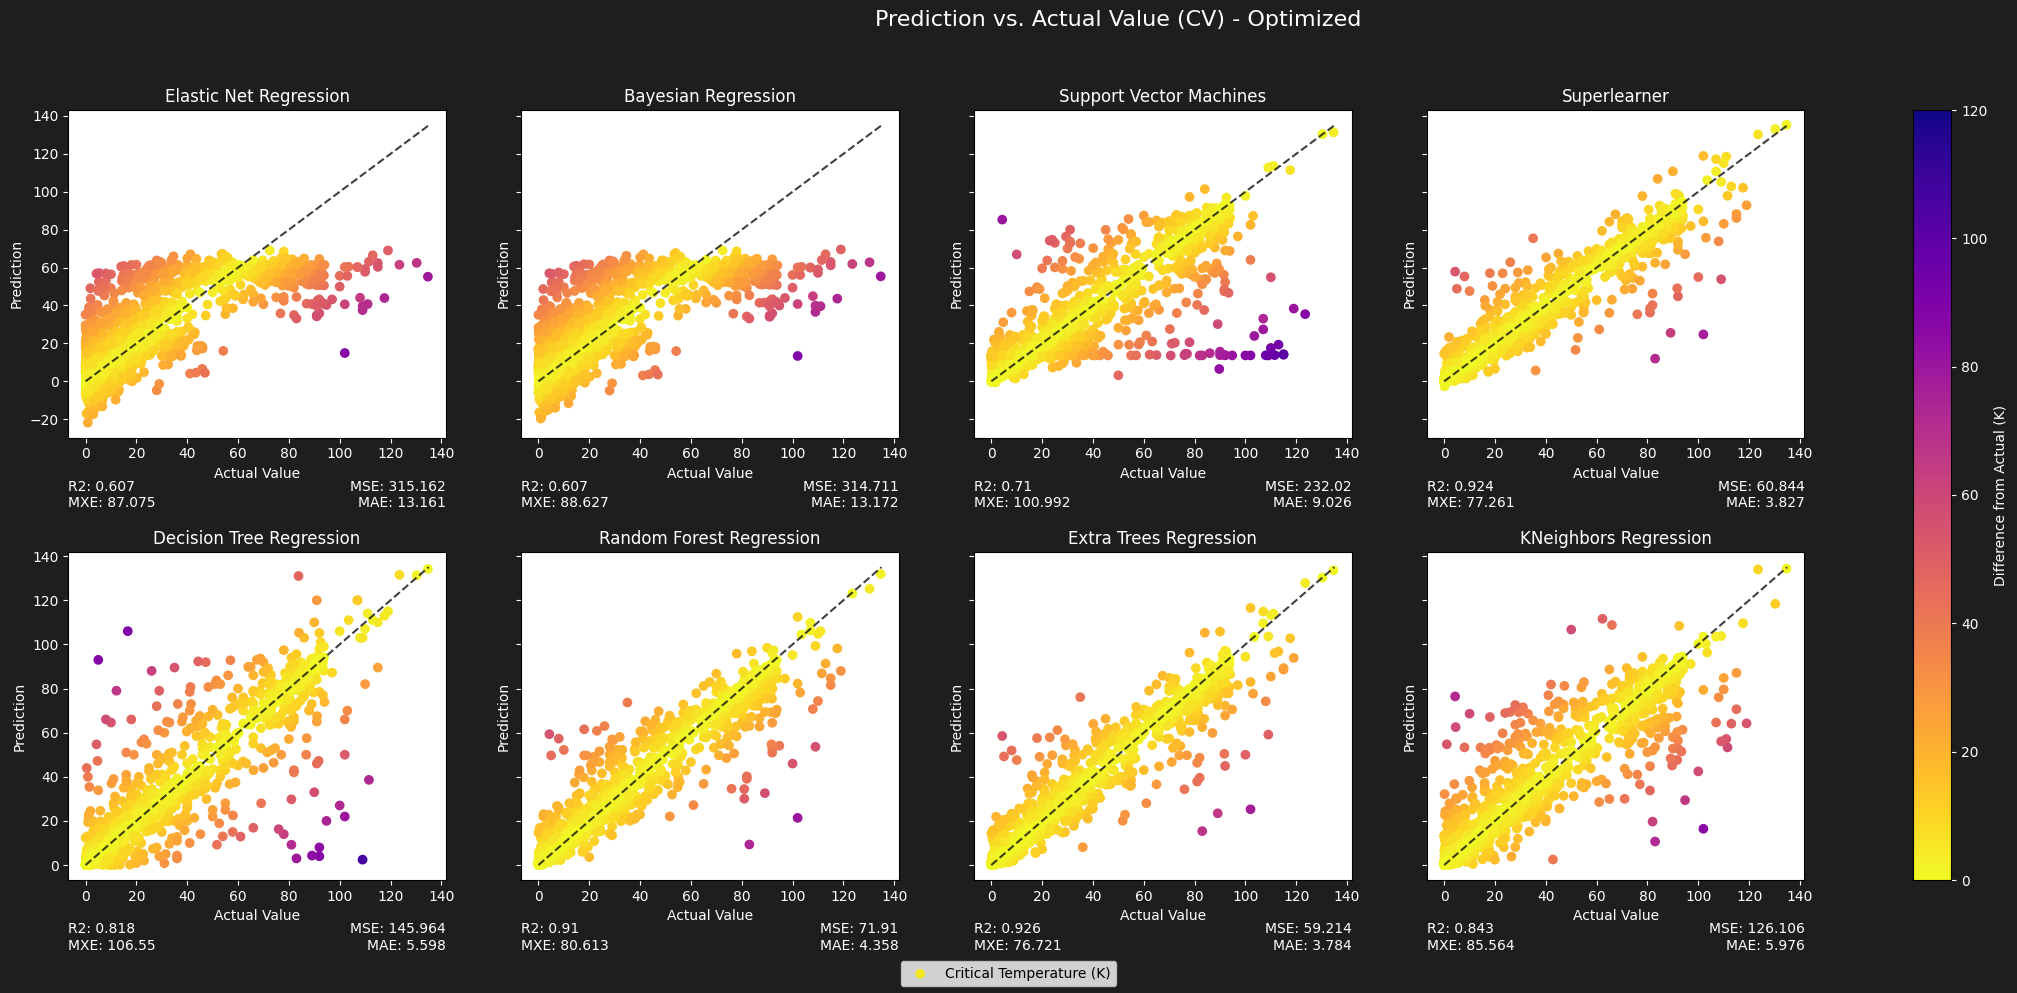

In [10]:
sfn.import_data(replace_inf=True)

#defines the optimized arguments for each model
ELASTIC_ARGS = {'alpha':1e-05, 'l1_ratio':0.0}
BAYES_ARGS = {}
SVR_ARGS = {'kernel':'rbf', 'C':100, 'epsilon':0.1, 'gamma':0.1, 'degree':1}
RFR_ARGS = {'max_features': 'auto', 'n_estimators': 250}
SP_ARGS = {'X': sfn.train_data}
KNN_ARGS = {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}
DT_ARGS = {'criterion':'poisson', 'max_features':0.5, 'random_state':43}
TREES_ARGS = {'n_estimators': 708}


sfn.import_data(replace_inf=True)
models  =  ((("Elastic Net Regression", ElasticNet, ELASTIC_ARGS, False),           ("Decision Tree Regression", DecisionTreeRegressor, DT_ARGS, False)),
            (("Bayesian Regression", BayesianRidge, BAYES_ARGS, False),             ("Random Forest Regression", RandomForestRegressor, RFR_ARGS, False)),
            (("Support Vector Machines", SVR, SVR_ARGS, False),                     ("Extra Trees Regression", ExtraTreesRegressor, TREES_ARGS, False)),
            (("Superlearner", Superlearner, SP_ARGS, False),                        ("KNeighbors Regression", KNeighborsRegressor, KNN_ARGS, False)))

sfn.evaluate(models, title="Prediction vs. Actual Value (CV) - Optimized", filename="results_optimized", forestci=False, method="plus", image=False)

## Bayesian Optimized Models
(*using PI*)

Starting training on Random Forest - Optimized
('Random Forest - Optimized', 71.586, 4.329, 80.955, 0.911, 38.061)


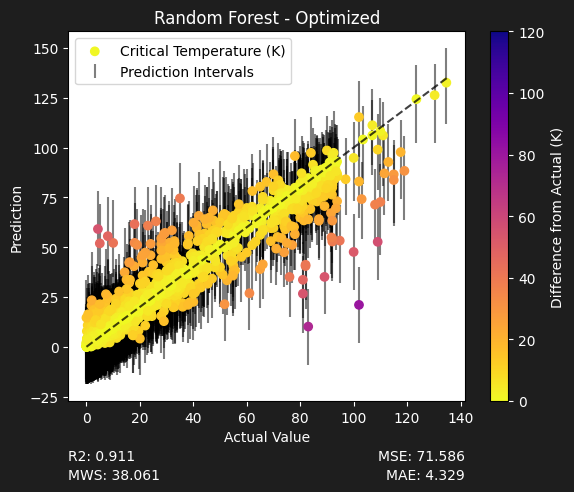

Starting training on Extra Trees - Optimized
('Extra Trees - Optimized', 58.86, 3.778, 76.239, 0.927, 35.467)


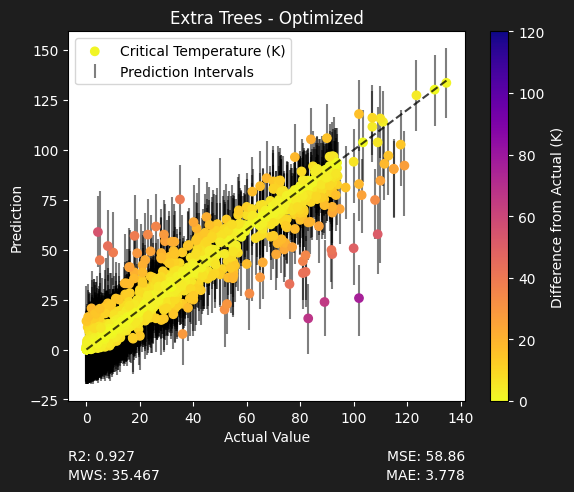

Starting training on KNeighbors - Optimized
('KNeighbors - Optimized', 154.683, 6.748, 79.35, 0.807, 57.802)


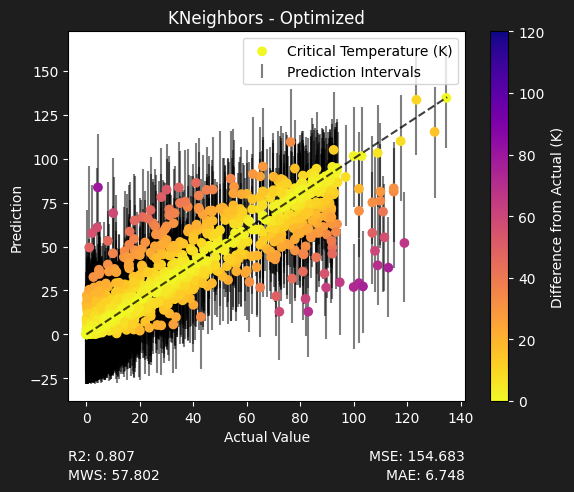

<Figure size 640x480 with 0 Axes>

In [14]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest - Optimized", RandomForestRegressor, {'max_features': 17, 'n_estimators': 999}, uncertainty=True, method="plus")
sfn.evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'n_estimators': 933}, uncertainty=True, method="plus")
sfn.evaluate_one("KNeighbors - Optimized", KNeighborsRegressor, {'n_neighbors': 4, 'algorithm': 'kd_tree'}, uncertainty=True, method="plus")

(*using EI*)

Starting training on Random Forest - Optimized
('Random Forest - Optimized', 72.136, 4.335, 80.416, 0.91, 38.265)


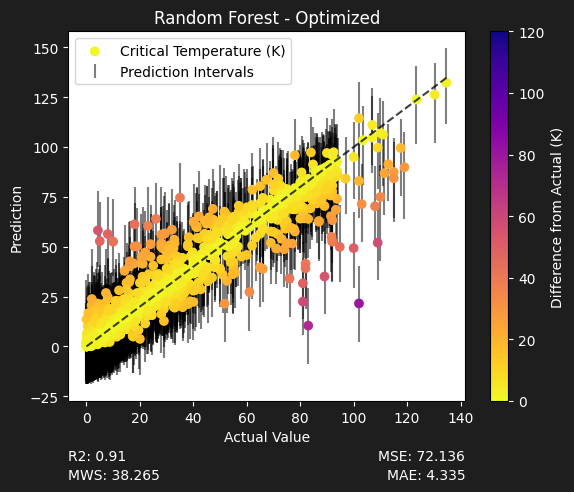

Starting training on Extra Trees - Optimized
('Extra Trees - Optimized', 58.708, 3.779, 73.064, 0.927, 36.205)


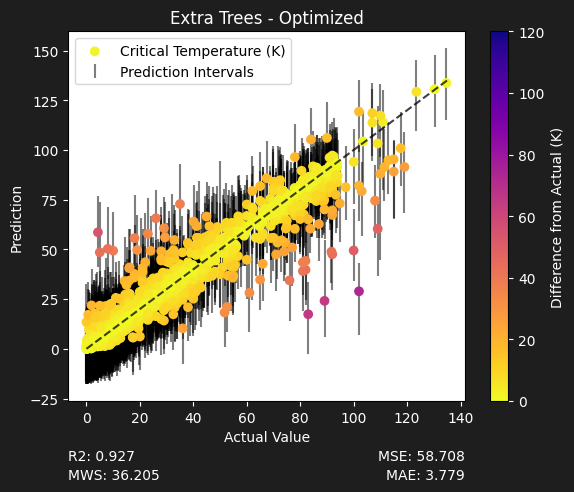

Starting training on KNeighbors - Optimized
('KNeighbors - Optimized', 150.997, 6.302, 82.0, 0.812, 60.035)


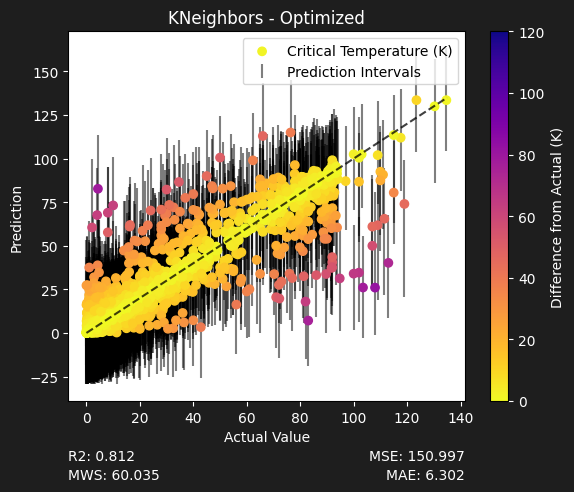

<Figure size 640x480 with 0 Axes>

In [15]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest - Optimized", RandomForestRegressor, {'max_features': 20, 'n_estimators': 540}, uncertainty=True, method="plus")
sfn.evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'n_estimators': 119}, uncertainty=True, method="plus")
sfn.evaluate_one("KNeighbors - Optimized", KNeighborsRegressor, {'n_neighbors': 2, 'algorithm': 'auto'}, uncertainty=True, method="plus")


(*using gp_hedge*)

Starting training on Random Forest - Optimized
('Random Forest - Optimized', 73.659, 4.399, 80.316, 0.908, 38.203)


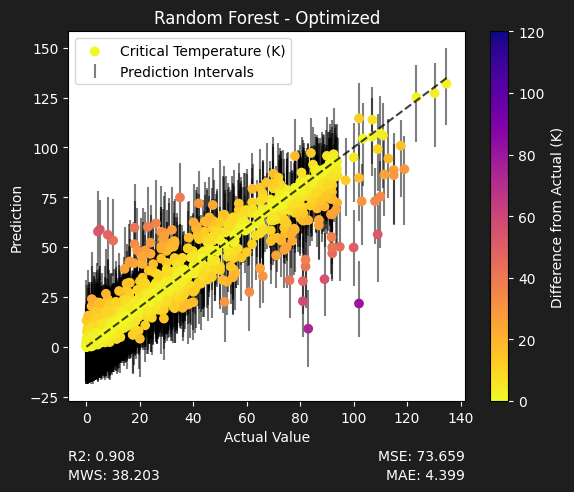

Starting training on Extra Trees - Optimized
('Extra Trees - Optimized', 58.706, 3.771, 75.803, 0.927, 35.635)


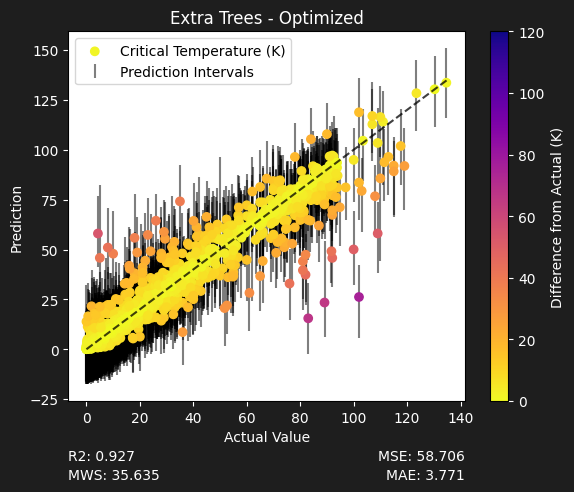

Starting training on KNeighbors - Optimized
('KNeighbors - Optimized', 168.329, 6.475, 85.5, 0.79, 65.486)


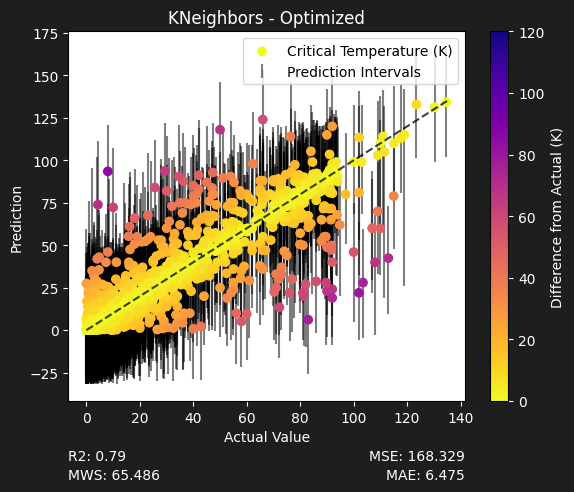

<Figure size 640x480 with 0 Axes>

In [16]:
sfn.import_data(replace_inf=True)
sfn.evaluate_one("Random Forest - Optimized", RandomForestRegressor, {'max_features': 20, 'n_estimators': 143}, uncertainty=True, method="plus")
sfn.evaluate_one("Extra Trees - Optimized", ExtraTreesRegressor, {'n_estimators': 291}, uncertainty=True, method="plus")
sfn.evaluate_one("KNeighbors - Optimized", KNeighborsRegressor, {'n_neighbors': 1, 'algorithm': 'kd_tree'}, uncertainty=True, method="plus")